In [3]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached grpcio-1.71.0-cp312-cp312-win_amd64.whl.metadata (4.0 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.9.2-py3-none-any.whl.metadata (6.1 kB)
  Using cached ml_dtypes-0.5.1-cp312-cp312-win_amd64.whl.metadata (22 kB)
  Using cached namex-0.0.9-py3-none-any.whl.metadata (322 bytes)
  Using cached optree-0.15

In [3]:
!pip install mysql-connector-python

   ---------------------------------------- 0.0/16.4 MB ? eta -:--:--
   ------- -------------------------------- 3.1/16.4 MB 15.3 MB/s eta 0:00:01
   ---------------- ----------------------- 6.8/16.4 MB 17.5 MB/s eta 0:00:01
   ------------------------- -------------- 10.5/16.4 MB 17.2 MB/s eta 0:00:01
   ---------------------------------- ----- 14.2/16.4 MB 17.4 MB/s eta 0:00:01
   ---------------------------------------- 16.4/16.4 MB 16.9 MB/s eta 0:00:00


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os
import pickle

Epoch 1/50


C:\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.6168
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.6040
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - loss: 0.5914
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.5789
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - loss: 0.5665
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.5540
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.5415
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.5289
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5162
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step - loss: 0.5035
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.4906
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.4775
Epoch 13/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - loss: 0.4644
Epoch 14/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.4511
Epoch 15/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - loss: 0.4374
Epoch 16/50
1/1 ━━━━━━━━━━━━━━━━━

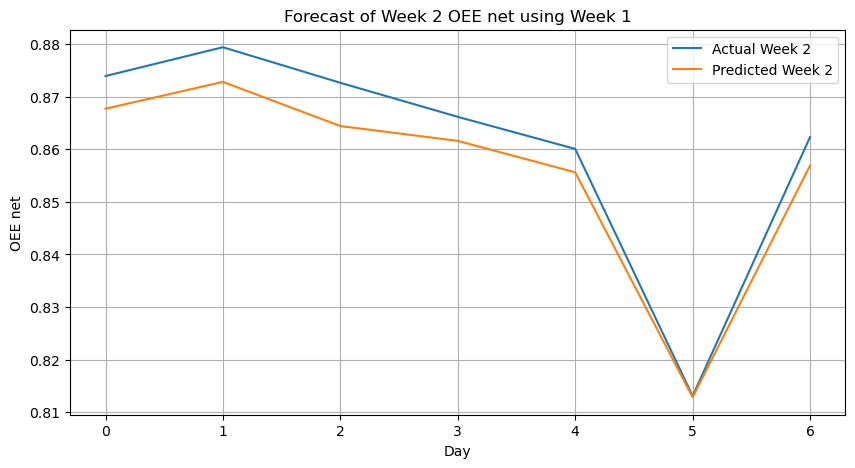

Previous data cleared from predicted_oee table.
Predicted OEE_net values successfully saved to MySQL table `predicted_oee`.


In [13]:
# Connect to MySQL (ensure the database is accessible online)
conn = mysql.connector.connect(
    host="localhost",   # Public IP or cloud-hosted database
    user="root",
    password="",
    database="cookies"
)
# Create a cursor object
cursor = conn.cursor()
# Define SQL query
query = "SELECT * FROM cookies_production"  # Modify as needed
# Execute the query
cursor.execute(query)
# Fetch column names
columns = [desc[0] for desc in cursor.description]
# Fetch data and store it in a Pandas DataFrame
data = cursor.fetchall()
df = pd.DataFrame(data, columns=columns)

df["StartDateTime"] = pd.to_datetime(df["StartDateTime"], dayfirst=True)
df["Date"] = df["StartDateTime"].dt.date
daily_oee = df.groupby("Date")["OEE_net"].mean().reset_index()
daily_oee.columns = ["Date", "OEE_net"]
daily_oee["Date"] = pd.to_datetime(daily_oee["Date"])
daily_oee = daily_oee.sort_values("Date").set_index("Date")
data_2weeks = daily_oee.iloc[:14]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data_2weeks)
X_train = scaled[:7].reshape(1, 7, 1)
y_train = scaled[7:].reshape(1, 7)
X_test = X_train
y_test = y_train
model = Sequential([
    LSTM(64, activation='relu', input_shape=(7, 1)),
    Dense(7)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, verbose=1)

# Save the model
model_save_path = "oee_forecast_model.keras"  # You can change this path as needed
model.save(model_save_path)
print(f"Model saved to {model_save_path}")

# Save the scaler using pickle
scaler_filename = "oee_scaler.pkl"
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)
print(f"Scaler saved to {scaler_filename}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(y_pred.shape)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)
mse = mean_squared_error(y_test_inv.flatten(), y_pred_inv.flatten())
mae = mean_absolute_error(y_test_inv.flatten(), y_pred_inv.flatten())
r2 = r2_score(y_test_inv.flatten(), y_pred_inv.flatten())
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(y_test_inv.flatten(), label='Actual Week 2')
plt.plot(y_pred_inv.flatten(), label='Predicted Week 2')
plt.title("Forecast of Week 2 OEE net using Week 1")
plt.xlabel("Day")
plt.ylabel("OEE net")
plt.legend()
plt.grid()
plt.show()

# Save predictions to database
pred_week2 = y_pred_inv.flatten()
pred_df = pd.DataFrame({
    "Day": [f"Day {i+1}" for i in range(7)],
    "OEE_net_predicted": pred_week2
})

try:
    cursor.execute("TRUNCATE TABLE predicted_oee")
    conn.commit()
    print("Previous data cleared from predicted_oee table.")
except Exception as e:
    print(f"Error truncating table: {e}")

for i, row in pred_df.iterrows():
    cursor.execute("INSERT INTO predicted_oee (day, OEE_net_predicted) VALUES (%s, %s)",
                  (row["Day"], float(row["OEE_net_predicted"])))
conn.commit()
print("Predicted OEE_net values successfully saved to MySQL table `predicted_oee`.")